# DAT341 A5 Dermatological image classification
## GROUP 12
## WEIYOU WANG, GUANGYU MA, YANPING TANG
## Training Environment(local laptop)：13th Gen Intel(R) Core(TM) i5-13400F，32G RAM, NVIDIA 4060

### PART1 : Loading pictures and show them

In [1]:
#seting super parameter
batch_size=32
num_epochs = 10  

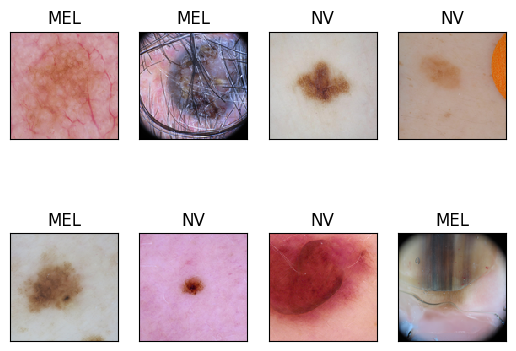

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

folder = ImageFolder('train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=batch_size, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

### PART2: Basic model(CNN)
#### No any optimize tech

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# 1️ data pre-processing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# 2️ load data
train_dataset = ImageFolder(root='train', transform=transform)
val_dataset = ImageFolder(root='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes) #class number
# Use cuda to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import pandas as pd
columns = ['Model','Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'Epoch Time']
history = pd.DataFrame(columns=columns)

In [7]:
# 3.BASIC CNN MODEL
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (32, 128, 128)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (64, 128, 128)
        self.pool = nn.MaxPool2d(2, 2)                           # (64, 64, 64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (128, 64, 64)
        self.pool2 = nn.MaxPool2d(2, 2)                          # (128, 32, 32)

        # dynamic computing the node size
        self._to_linear = None
        self._get_flattened_input_size()

        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flattened_input_size(self):
        x = torch.rand(1, 3, 128, 128)  
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool2(torch.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        self._to_linear = x.shape[1]

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool2(torch.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize model
model = BasicCNN(num_classes=num_classes).to(device)

# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train and verification
total_time = 0  # time record

for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()  
    
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    
    model.eval() 
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total  
    
    # save data infor 
    end_event.record()  
    torch.cuda.synchronize() 
    epoch_time = start_event.elapsed_time(end_event) / 1000 
    epoch_data = pd.DataFrame({
        'Model':['BasicCNN'],
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss/len(train_loader)],
        'Train Acc': [train_acc/100],
        'Val Loss': [val_loss/len(val_loader)],
        'Val Acc': [val_acc/100],
        'Epoch Time': [epoch_time]
    })
    history = pd.concat([history, epoch_data], ignore_index=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%|"
          f"Epoch time: {epoch_time:.1f}"
         )
history.to_csv('history.csv')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16876\3454620262.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, epoch_data], ignore_index=True)


Epoch [1/10], Train Loss: 0.4492, Train Acc: 76.24% | Val Loss: 0.4159, Val Acc: 80.19%|Epoch time: 14.7
Epoch [2/10], Train Loss: 0.3915, Train Acc: 80.72% | Val Loss: 0.3908, Val Acc: 82.03%|Epoch time: 14.3
Epoch [3/10], Train Loss: 0.3704, Train Acc: 82.29% | Val Loss: 0.3671, Val Acc: 82.27%|Epoch time: 14.5
Epoch [4/10], Train Loss: 0.3406, Train Acc: 83.86% | Val Loss: 0.3603, Val Acc: 81.55%|Epoch time: 14.6
Epoch [5/10], Train Loss: 0.3210, Train Acc: 85.48% | Val Loss: 0.3696, Val Acc: 81.47%|Epoch time: 14.6
Epoch [6/10], Train Loss: 0.2956, Train Acc: 86.45% | Val Loss: 0.3823, Val Acc: 82.59%|Epoch time: 14.7
Epoch [7/10], Train Loss: 0.2595, Train Acc: 88.38% | Val Loss: 0.3645, Val Acc: 83.31%|Epoch time: 14.6
Epoch [8/10], Train Loss: 0.2182, Train Acc: 90.82% | Val Loss: 0.3888, Val Acc: 82.83%|Epoch time: 14.4
Epoch [9/10], Train Loss: 0.1788, Train Acc: 92.42% | Val Loss: 0.4507, Val Acc: 82.91%|Epoch time: 14.4
Epoch [10/10], Train Loss: 0.1435, Train Acc: 94.06% | 

# Part3 improved model
## 3-1 Normalization

In [14]:
# basic CNN MODEL WITH Batch Normalization
class BasicCNN_Nor(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN_Nor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (32, 128, 128)
        self.bn1 = nn.BatchNorm2d(32)  #  Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (64, 128, 128)
        self.bn2 = nn.BatchNorm2d(64)  #  Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)                           # (64, 64, 64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (128, 64, 64)
        self.bn3 = nn.BatchNorm2d(128) #  Batch Normalization
        self.pool2 = nn.MaxPool2d(2, 2)                          # (128, 32, 32)

        self._to_linear = None
        self._get_flattened_input_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flattened_input_size(self):
        x = torch.rand(1, 3, 128, 128)  
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) 
        x = self.pool(torch.relu(self.bn2(self.conv2(x)))) 
        x = self.pool2(torch.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, start_dim=1)
        self._to_linear = x.shape[1]

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) 
        x = self.pool(torch.relu(self.bn2(self.conv2(x)))) 
        x = self.pool2(torch.relu(self.bn3(self.conv3(x)))) 
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BasicCNN_Nor(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
total_time = 0  # time record
history = pd.DataFrame(columns=columns)

for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()  
    
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  

        train_loss += loss.item()
        _, predicted = outputs.max(1) 
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total 
    
    # **verify**
    model.eval() 
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total  

    end_event.record()  
    torch.cuda.synchronize() 
    epoch_time = start_event.elapsed_time(end_event) / 1000 
    total_time += epoch_time  

    epoch_data = pd.DataFrame({
        'Model':['BasicCNN_Nor'],
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss/len(train_loader)],
        'Train Acc': [train_acc/100],
        'Val Loss': [val_loss/len(val_loader)],
        'Val Acc': [val_acc/100],
        'Epoch Time': [epoch_time]
    })
    history = pd.concat([history, epoch_data], ignore_index=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%|"
          f"Epoch time: {epoch_time:.1f}"
         )
    
history.to_csv('history.csv',mode='a',header=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16876\2868380875.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, epoch_data], ignore_index=True)


Epoch [1/10], Train Loss: 0.7550, Train Acc: 76.11% | Val Loss: 0.4969, Val Acc: 74.36%|Epoch time: 13.6
Epoch [2/10], Train Loss: 0.3916, Train Acc: 80.45% | Val Loss: 0.3818, Val Acc: 80.91%|Epoch time: 13.9
Epoch [3/10], Train Loss: 0.3651, Train Acc: 82.10% | Val Loss: 0.3847, Val Acc: 81.95%|Epoch time: 13.7
Epoch [4/10], Train Loss: 0.3609, Train Acc: 82.76% | Val Loss: 0.3540, Val Acc: 83.07%|Epoch time: 13.5
Epoch [5/10], Train Loss: 0.3316, Train Acc: 84.42% | Val Loss: 0.3505, Val Acc: 83.87%|Epoch time: 13.7
Epoch [6/10], Train Loss: 0.3263, Train Acc: 84.45% | Val Loss: 0.3859, Val Acc: 79.87%|Epoch time: 13.6
Epoch [7/10], Train Loss: 0.3122, Train Acc: 85.50% | Val Loss: 0.3759, Val Acc: 83.55%|Epoch time: 13.4
Epoch [8/10], Train Loss: 0.3059, Train Acc: 86.18% | Val Loss: 0.3861, Val Acc: 81.87%|Epoch time: 13.1
Epoch [9/10], Train Loss: 0.2943, Train Acc: 86.80% | Val Loss: 0.3875, Val Acc: 82.19%|Epoch time: 13.4
Epoch [10/10], Train Loss: 0.2818, Train Acc: 87.36% | 

## 3-2 Residual connections

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define CNN with Residual Blocks
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(32, 2, stride=1)
        self.layer2 = self.make_layer(64, 2, stride=2)
        self.layer3 = self.make_layer(128, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# initialize model
model = ResNet(num_classes=num_classes).to(device)
history = pd.DataFrame(columns=columns)
# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train and verification
num_epochs = 10
total_time = 0  # time record

for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()  
    
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    
    model.eval() 
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total  
    
    #save data infor 
    end_event.record()  
    torch.cuda.synchronize() 
    epoch_time = start_event.elapsed_time(end_event) / 1000 
    epoch_data = pd.DataFrame({
        'Model':['ResNet'],
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss/len(train_loader)],
        'Train Acc': [train_acc/100],
        'Val Loss': [val_loss/len(val_loader)],
        'Val Acc': [val_acc/100],
        'Epoch Time': [epoch_time]
    })
    history = pd.concat([history, epoch_data], ignore_index=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%|"
          f"Epoch time: {epoch_time:.1f}"
         )
history.to_csv('history.csv',mode='a',header=False)

Epoch [1/10], Train Loss: 0.4971, Train Acc: 74.53% | Val Loss: 0.4518, Val Acc: 77.00%|Epoch time: 28.4
Epoch [2/10], Train Loss: 0.4474, Train Acc: 77.72% | Val Loss: 0.4393, Val Acc: 77.48%|Epoch time: 28.1
Epoch [3/10], Train Loss: 0.4312, Train Acc: 78.87% | Val Loss: 0.4175, Val Acc: 77.32%|Epoch time: 27.7
Epoch [4/10], Train Loss: 0.4184, Train Acc: 79.83% | Val Loss: 0.4025, Val Acc: 79.47%|Epoch time: 27.6
Epoch [5/10], Train Loss: 0.4079, Train Acc: 80.08% | Val Loss: 0.3910, Val Acc: 80.91%|Epoch time: 27.8
Epoch [6/10], Train Loss: 0.3945, Train Acc: 81.28% | Val Loss: 0.3729, Val Acc: 81.63%|Epoch time: 28.3
Epoch [7/10], Train Loss: 0.3802, Train Acc: 81.87% | Val Loss: 0.3513, Val Acc: 83.07%|Epoch time: 28.2
Epoch [8/10], Train Loss: 0.3703, Train Acc: 82.32% | Val Loss: 0.3798, Val Acc: 81.23%|Epoch time: 27.9
Epoch [9/10], Train Loss: 0.3639, Train Acc: 83.27% | Val Loss: 0.4121, Val Acc: 78.91%|Epoch time: 27.9
Epoch [10/10], Train Loss: 0.3577, Train Acc: 82.93% | 

## 3-3 Data augmentation by applying random transformations to the images


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pandas as pd

# 1️ data pre-processing WITH augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(),  # random flip
    transforms.RandomRotation(10),      # random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# avoid The data distribution of the validation set is inconsistent with the real data, which affects the accuracy
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 2️ load data
train_dataset = ImageFolder(root='train', transform=transform)
#val_dataset = ImageFolder(root='val', transform=transform)
val_dataset = ImageFolder(root='val', transform=val_transform)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes) #class number
# Use cuda to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# initialize model
model = BasicCNN(num_classes=num_classes).to(device)

# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train and verification
total_time = 0  # time record
num_epochs = 10 
history = pd.DataFrame()

for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()  
    
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    
    model.eval() 
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total  
    
    # save data infor 
    end_event.record()  
    torch.cuda.synchronize() 
    epoch_time = start_event.elapsed_time(end_event) / 1000 
    epoch_data = pd.DataFrame({
        'Model':['Augmentation_v2'],
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss/len(train_loader)],
        'Train Acc': [train_acc/100],
        'Val Loss': [val_loss/len(val_loader)],
        'Val Acc': [val_acc/100],
        'Epoch Time': [epoch_time]
    })
    history = pd.concat([history, epoch_data], ignore_index=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%|"
          f"Epoch time: {epoch_time:.1f}"
         )

Using device: cuda
Epoch [1/10], Train Loss: 0.5001, Train Acc: 73.70% | Val Loss: 0.4300, Val Acc: 78.12%|Epoch time: 17.9
Epoch [2/10], Train Loss: 0.4446, Train Acc: 78.03% | Val Loss: 0.4269, Val Acc: 78.59%|Epoch time: 17.1
Epoch [3/10], Train Loss: 0.4192, Train Acc: 79.69% | Val Loss: 0.3852, Val Acc: 80.59%|Epoch time: 17.5
Epoch [4/10], Train Loss: 0.3993, Train Acc: 80.50% | Val Loss: 0.3868, Val Acc: 79.63%|Epoch time: 17.8
Epoch [5/10], Train Loss: 0.3819, Train Acc: 81.25% | Val Loss: 0.4470, Val Acc: 76.92%|Epoch time: 17.4
Epoch [6/10], Train Loss: 0.3702, Train Acc: 82.51% | Val Loss: 0.3636, Val Acc: 80.75%|Epoch time: 18.1
Epoch [7/10], Train Loss: 0.3638, Train Acc: 82.51% | Val Loss: 0.3604, Val Acc: 80.83%|Epoch time: 19.0
Epoch [8/10], Train Loss: 0.3512, Train Acc: 83.13% | Val Loss: 0.3614, Val Acc: 81.87%|Epoch time: 18.5
Epoch [9/10], Train Loss: 0.3451, Train Acc: 83.58% | Val Loss: 0.3691, Val Acc: 82.11%|Epoch time: 17.8
Epoch [10/10], Train Loss: 0.3311, T

In [20]:
history.to_csv('history.csv',mode='a',header=False)

## 3-4 Pre-trained model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import torch.cuda

vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

for param in vgg16.parameters():
    param.requires_grad = False 
for param in vgg16.classifier.parameters():
    param.requires_grad = True  

vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

total_time = 0 
history = pd.DataFrame(columns=columns)
for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()  
    
    vgg16.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    
    vgg16.eval() 
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100. * correct / total  
    
    end_event.record()  
    torch.cuda.synchronize() 
    epoch_time = start_event.elapsed_time(end_event) / 1000 
    epoch_data = pd.DataFrame({
        'Model':['VGG16'],
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss/len(train_loader)],
        'Train Acc': [train_acc/100],
        'Val Loss': [val_loss/len(val_loader)],
        'Val Acc': [val_acc/100],
        'Epoch Time': [epoch_time]
    })
    history = pd.concat([history, epoch_data], ignore_index=True)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}% | "
          f"Epoch time: {epoch_time:.1f}s"
         )
history.to_csv('history.csv',mode='a',header=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16876\347426388.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, epoch_data], ignore_index=True)


Epoch [1/10], Train Loss: 0.5552, Train Acc: 79.37% | Val Loss: 0.5492, Val Acc: 78.27% | Epoch time: 26.6s
Epoch [2/10], Train Loss: 0.5017, Train Acc: 82.12% | Val Loss: 0.4549, Val Acc: 80.27% | Epoch time: 26.8s
Epoch [3/10], Train Loss: 0.4485, Train Acc: 83.30% | Val Loss: 0.5750, Val Acc: 79.07% | Epoch time: 26.7s
Epoch [4/10], Train Loss: 0.4051, Train Acc: 84.20% | Val Loss: 0.3583, Val Acc: 84.98% | Epoch time: 26.9s
Epoch [5/10], Train Loss: 0.3767, Train Acc: 85.89% | Val Loss: 0.3812, Val Acc: 83.07% | Epoch time: 26.8s
Epoch [6/10], Train Loss: 0.3141, Train Acc: 86.76% | Val Loss: 0.3532, Val Acc: 84.58% | Epoch time: 26.3s
Epoch [7/10], Train Loss: 0.3227, Train Acc: 87.68% | Val Loss: 0.4541, Val Acc: 82.35% | Epoch time: 26.2s
Epoch [8/10], Train Loss: 0.2910, Train Acc: 88.81% | Val Loss: 0.3850, Val Acc: 84.74% | Epoch time: 25.6s
Epoch [9/10], Train Loss: 0.3666, Train Acc: 87.36% | Val Loss: 0.4721, Val Acc: 84.35% | Epoch time: 25.6s
Epoch [10/10], Train Loss: 0